In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport manual_review_classifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from manual_review_classifier.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot
from manual_review_classifier.Analysis import print_accuracy_and_classification_report, predict_classes, get_somatic_error_type

sns.set_style("white")
sns.set_context('poster')

In [4]:
# Pull in training data
training_data = pd.read_pickle('../data/training_data.pkl')
training_data.sort_index(axis=1, inplace=True)

In [5]:
# Remove AML31 case
aml31_training = training_data[training_data.index.str.contains('H_KA-452198')]
training_data = training_data[~training_data.index.str.contains('H_KA-452198')]

In [6]:
# Show the calls associate with training data
training_data.groupby('call').size()

call
a    10643
f     8854
g     3122
s    18381
dtype: int64

In [7]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Somatic, ambigous, fail classifier

In [8]:
# Re-label the germline calls as failed calls
three_class = training_data.replace('g','f')
three_class.sort_index(axis=1, inplace=True)

In [9]:
# Show the calls associate with training data
three_class.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [10]:
# Get labels for training data
Y = three_class.call.values
# Get training data as numpy array
X = training_data.drop(['call'], axis=1).astype(float).values

In [11]:
# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [12]:
# Determine shape of training data features for cross-validation
X_train.shape

(27470, 71)

In [13]:
# Determine shape of training data calls for cross-validation
Y_train.shape

(27470,)

In [14]:
# Set parameters for the Random Forest Model
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y_train)

In [15]:
# Perform cross validation and pull AUC for various splits
auc = []
for n in [100, 1000, 10000]:
    est = RandomForestClassifier(n_estimators=n, max_features=8,n_jobs=-1, 
                                 oob_score=True)
    probs = cross_val_predict(est, X_train, Y_train, cv=kfold, method='predict_proba')
    temp_auc = []
    for j in range(Y_one_hot.shape[1]):
        temp_auc.append(metrics.roc_auc_score(Y_one_hot[:, j], probs[:, j]))
    auc.append(temp_auc)
    print('Test AUC for {0} trees: '.format(n), temp_auc)
    print('---------------------------------------------------------')

Test AUC for 100 trees:  [0.96034643225129546, 0.99010306587510277, 0.97961389165182744]
---------------------------------------------------------
Test AUC for 1000 trees:  [0.96158398619578533, 0.99047237791259091, 0.98014893261202507]
---------------------------------------------------------
Test AUC for 10000 trees:  [0.96162403074746672, 0.99047818814408162, 0.98014321923830594]
---------------------------------------------------------


In [16]:
# Set parameters for the extimator
estimator = RandomForestClassifier(n_estimators=1000, max_features=8, 
                                   n_jobs=-1, oob_score=True)

In [17]:
# Perform cross validation
probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')

In [18]:
# Save the probabilities in /data folder
np.save('../data/random_forest/1000estimators.npy', probabilities)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [19]:
# print accuracy report
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.893119767019

Cross validation classification report

             precision    recall  f1-score   support

          0       0.85      0.78      0.82      7189
          1       0.91      0.92      0.92      8015
          2       0.90      0.94      0.92     12266

avg / total       0.89      0.89      0.89     27470



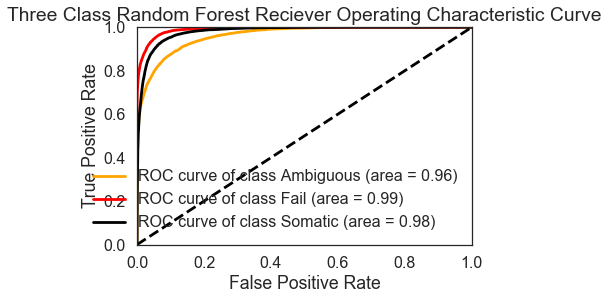

In [20]:
# Plot ROC for Random Forest Model
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Three Class Random'
                 ' Forest Reciever Operating Characteristic Curve', ax)

confidence intervals +-:  [ 0.00059489  0.00326484  0.00594923  0.00818674  0.00939782  0.00994163
  0.00903821  0.00665575  0.00418309  0.00070659]


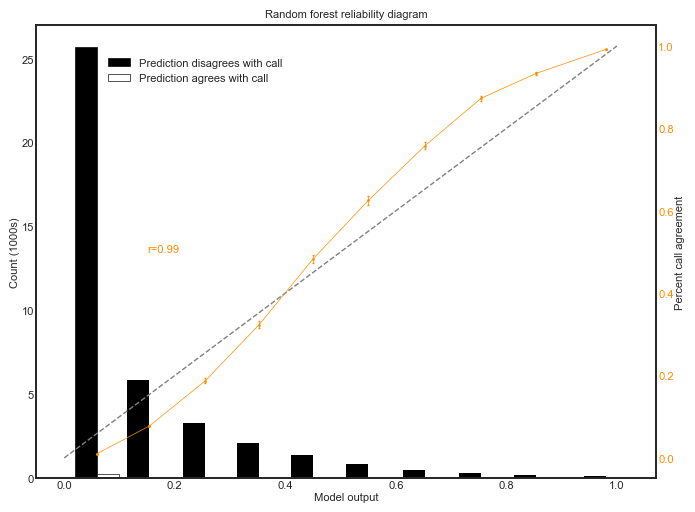

In [21]:
# Plot reliability diagram for Random Forest Model
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_one_hot,['Ambiguous','Fail','Somatic'], 'darkorange', 'Random forest reliability diagram',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

## Feature importance analysis

In [22]:
# Rebuild random forest model
forest = estimator.fit(X_train, Y_train)

In [23]:
# Sum the feature importance metrics for one-hot encoded variables
# (Feature importance calculation in scikit-learn is outlined 
# here https://stackoverflow.com/a/15821880/3862525).
# Since the importances are calculated with the same denominator, summing is
# appropriate
def sum_features(feature_import, label):
    starts_with_label = feature_import.feature.str.startswith(label)
    return feature_import.importance[starts_with_label].sum()

In [24]:
# Create function to determine the feature importance 
def create_feature_importance_plot(trained_model, save_fp='../data/random_forest/feature_import.pkl'):
    feature_import = pd.DataFrame([training_data.drop(['call'], axis=1).columns.values,trained_model.feature_importances_]).T
    feature_import.columns = ['feature', 'importance']
    summed_importances = []
    for label in ['disease', 'reviewer']:
        summed_importances.append([label, sum_features(feature_import, label)])
    summed_importances = pd.DataFrame(summed_importances, columns=['feature','importance'])
    feature_import.to_pickle(save_fp)
    feature_import.sort_values('importance', ascending=False, inplace=True)
    feature_import.replace({'feature':{'var':'variant','ref':'reference', 'avg':'average', '_se_':'_single_end_', '3p':'3_prime', '_':' '}}, regex=True, inplace=True)
    sns.barplot(y='feature', x='importance', data=feature_import.head(30), color='darkorange')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('Random forest feature importance')

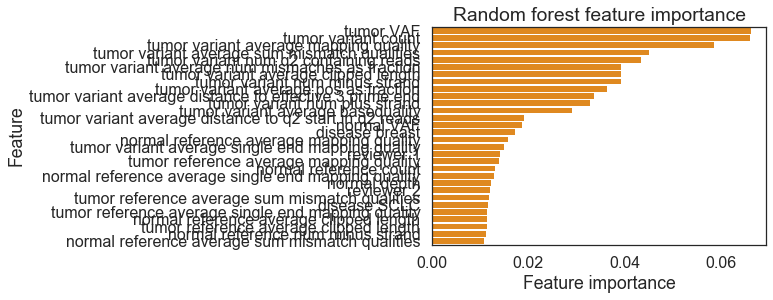

In [27]:
# Plot feature importance graph
create_feature_importance_plot(forest)

### Test set performance

In [28]:
# Determine performance on test set
test_prob = forest.predict_proba(X_test)

In [29]:
# Transform labels for predictions
Y_test_labels = enc.fit_transform(Y_test)

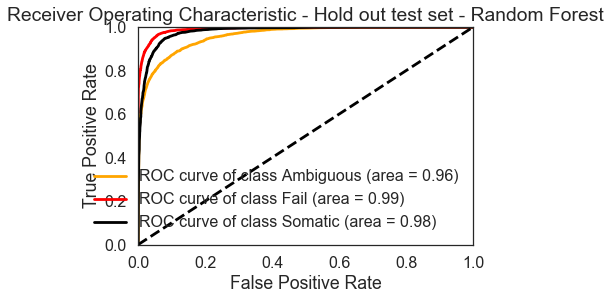

In [30]:
# Plot AUC for test set
fig, ax = plt.subplots()
create_roc_curve(Y_test_labels, test_prob, class_lookup, 'Receiver Operating '
                 'Characteristic - Hold out test set - '
                 'Random Forest', ax)

confidence intervals +-:  [ 0.00086513  0.00439553  0.00841053  0.0116627   0.01360325  0.0140986
  0.01258907  0.00940472  0.00575049  0.00108684]


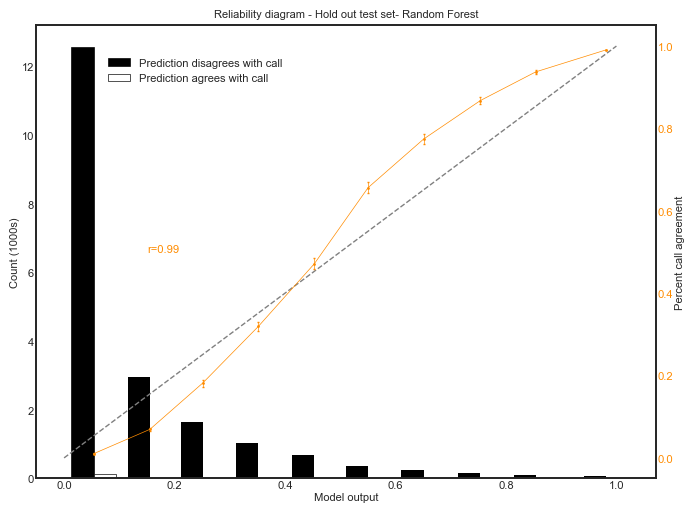

In [31]:
# Plot reliability diagram for test set
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(test_prob, Y_test_labels,
                                 ['Ambiguous','Fail','Somatic'], 
                                 'darkorange', 'Reliability diagram - Hold out test set'
                                 '- Random Forest',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

## Solid vs blood tumor

In [32]:
# Colapse disease types into solid vs liquid tumors
s_v_b = three_class
s_v_b['solid_tumor'] = s_v_b[['disease_GST', 'disease_MPNST', 'disease_SCLC',
                              'disease_breast', 'disease_colorectal', 
                              'disease_glioblastoma', 'disease_melanoma']].apply(any, axis=1).astype(int)
s_v_b.drop(['disease_AML', 'disease_GST', 'disease_MPNST', 'disease_SCLC',
       'disease_breast', 'disease_colorectal', 'disease_glioblastoma',
       'disease_lymphoma', 'disease_melanoma'], axis=1, inplace=True)

In [33]:
# Determine shape of new data set
s_v_b.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [34]:
# Get Labels
Y = s_v_b.call.values
# Get training data as numpy array
X = s_v_b.drop(['call'], axis=1).astype(float).values

In [35]:
# Split data into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [36]:
# Determine shape
X_train.shape

(27470, 63)

In [37]:
# Determine shape
Y_train.shape

(27470,)

In [38]:
# Determine cross validation probabilites
probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [39]:
# Show accuracy profile of the cross-validation
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y_train)
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.890243902439

Cross validation classification report

             precision    recall  f1-score   support

          0       0.85      0.78      0.81      7189
          1       0.91      0.92      0.91      8015
          2       0.90      0.94      0.92     12266

avg / total       0.89      0.89      0.89     27470



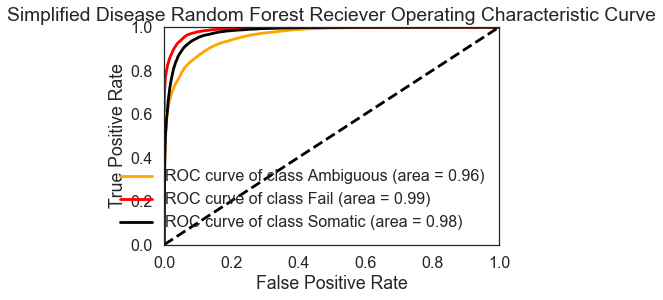

In [40]:
# Plot ROC curves 
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Simplified Disease '
                 'Random Forest Reciever Operating Characteristic Curve', ax)

confidence intervals +-:  [ 0.00062642  0.00325103  0.00584467  0.00787565  0.00928124  0.00982259
  0.00890041  0.00666285  0.00421607  0.00074018]


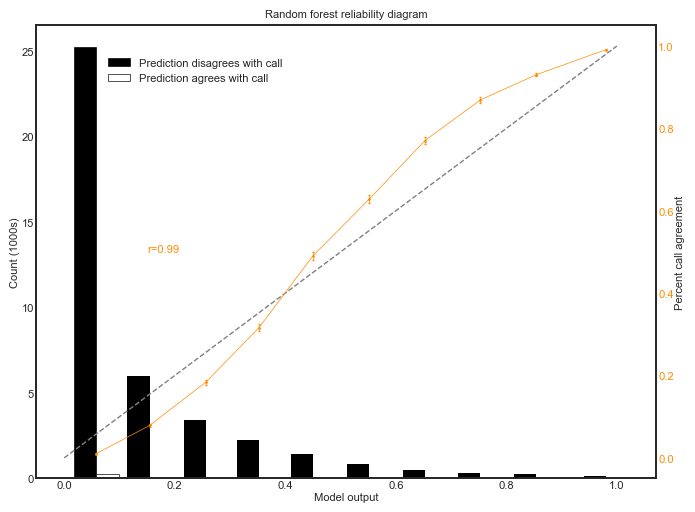

In [41]:
# Plot reliability diagram
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_one_hot,['Ambiguous','Fail','Somatic'], 'darkorange', 'Random forest reliability diagram',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

### Test set performance

In [42]:
#Get probabilites for hold out test set
forest = estimator.fit(X_train, Y_train)
test_prob = forest.predict_proba(X_test)

In [43]:
# Add labels
Y_test_labels = enc.fit_transform(Y_test)

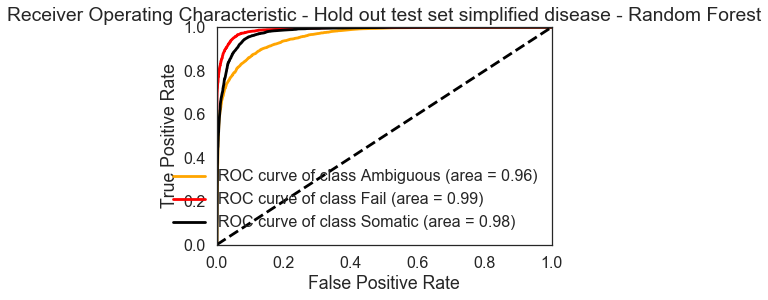

In [44]:
# PLot test set ROC
fig, ax = plt.subplots()
create_roc_curve(Y_test_labels, test_prob, class_lookup, 'Receiver Operating '
                 'Characteristic - Hold out test set simplified disease - '
                 'Random Forest', ax)

confidence intervals +-:  [ 0.00090388  0.00454519  0.00812143  0.01147647  0.01362626  0.0140075
  0.01243437  0.00909787  0.00584991  0.00115365]


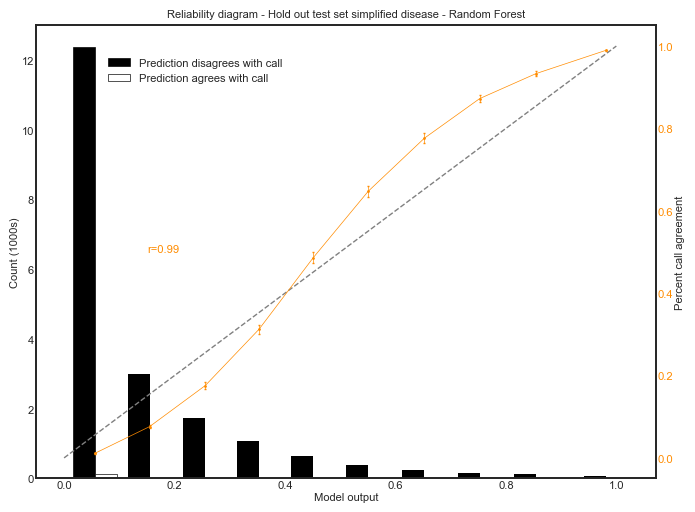

In [45]:
# Plot test set reliability diagram
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(test_prob, Y_test_labels,
                                 ['Ambiguous','Fail','Somatic'], 
                                 'darkorange', 'Reliability diagram - Hold out test set '
                                 'simplified disease - Random Forest',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

## Remove reviewer to simulate performance on de novo datasets

In [46]:
# Get Labels
Y = three_class.call.values
# Get training data as numpy array
s_v_b.sort_index(axis=1, inplace=True)
X = s_v_b.drop(['call', 'reviewer_1', 'reviewer_2', 'reviewer_3', 
                'reviewer_4'], axis=1).astype(float).values

In [47]:
# Test shape
X.shape

(41000, 59)

In [48]:
# Test shape
Y.shape

(41000,)

In [49]:
# Predict probabilites
probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [50]:
# Print accuracy profile
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y)
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.891926829268

Cross validation classification report

             precision    recall  f1-score   support

          0       0.85      0.78      0.81     10643
          1       0.92      0.92      0.92     11976
          2       0.90      0.94      0.92     18381

avg / total       0.89      0.89      0.89     41000



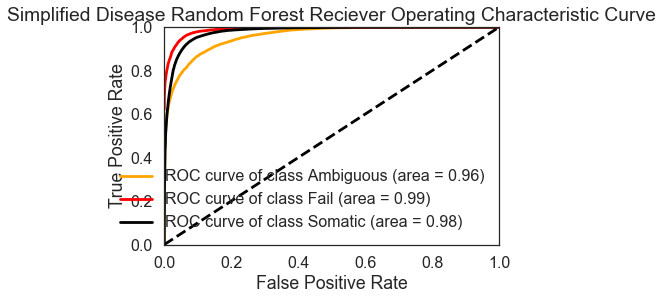

In [51]:
# Print ROC Curve for test set without reviewer
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Simplified Disease '
                 'Random Forest Reciever Operating Characteristic Curve', ax)

confidence intervals +-:  [ 0.00051377  0.00261438  0.00461825  0.0063447   0.00751079  0.00785689
  0.00690009  0.0051138   0.00336743  0.0006197 ]


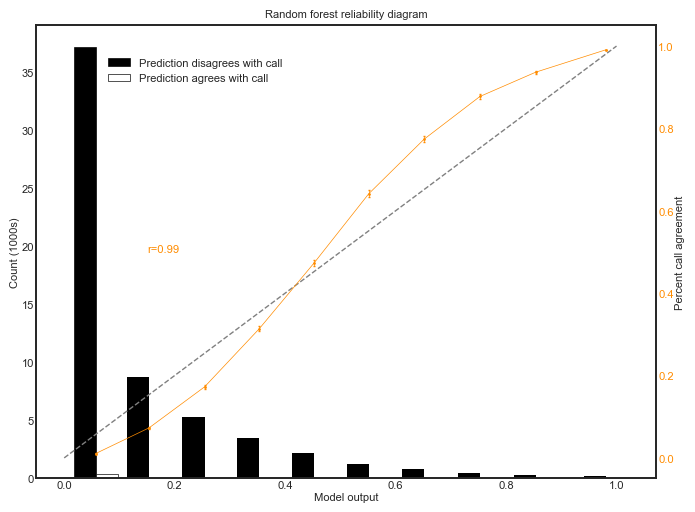

In [52]:
# Plot reliability diagram for test set without reviewer
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_one_hot,['Ambiguous','Fail','Somatic'], 'darkorange', 'Random forest reliability diagram',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

In [53]:
# Format probabilities and store as xval_model_results
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [54]:
cv_somatic_error = get_somatic_error_type(Y_one_hot, predicted)

In [55]:
cv_somatic_error.index = training_data.index

In [56]:
probs_df = pd.DataFrame(probabilities, columns=['Ambiguous', 'Fail', 'Somatic'], index=training_data.index)

In [57]:
cv_somatic_error = pd.concat([cv_somatic_error, probs_df], axis=1)

In [58]:
cv_somatic_error.to_pickle('../data/random_forest/xval_model_results.pkl')

# Independent test analysis

In [59]:
# Get Labels
Y = three_class.call.values
# Get training data as numpy array
s_v_b.sort_index(axis=1, inplace=True)
X = s_v_b.drop(['call', 'reviewer_1', 'reviewer_2', 'reviewer_3', 
                'reviewer_4'], axis=1).astype(float).values

In [60]:
X.shape

(41000, 59)

In [61]:
Y.shape

(41000,)

In [62]:
forest = estimator.fit(X, Y)

In [63]:
# test oob score metrics
forest.oob_score_

0.89212195121951221

## SCLC

In [64]:
# Pull in manual review validation set (SCLC cases)
sclc_data = pd.read_pickle('../data/independent_test/sclc_train.pkl')
# Label as solid tumor
sclc_data['solid_tumor'] = 1

In [65]:
# Pull in SCLC calls
sclc_call = pd.read_pickle('../data/independent_test/sclc_call.pkl')
sclc_call=sclc_call.map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')
sclc_call.value_counts()

s    2526
f     145
a      15
Name: call, dtype: int64

In [66]:
# Get Labels
sclc_Y = sclc_call.values
# Get training data as numpy array
sclc_X = sclc_data.sort_index(axis=1).drop(['disease_SCLC', 'reviewer_Erica', 'reviewer_Lee'], axis=1).astype(float).values

In [67]:
# Employ RF model on SCLC data
sclc_probs = forest.predict_proba(sclc_X)

In [68]:
# Print accuracy profile
sclc_Y_one_hot = enc.fit_transform(sclc_Y)
print_accuracy_and_classification_report(sclc_Y_one_hot, predict_classes(sclc_probs))

Cross validation accuracy:
	 0.807892777364

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        15
          1       0.10      0.15      0.12       145
          2       0.97      0.85      0.91      2526

avg / total       0.92      0.81      0.86      2686



In [69]:
# Save predictions
np.save('../data/random_forest/sclc_y.npy', sclc_Y_one_hot)
np.save('../data/random_forest/sclc_probs.npy', sclc_probs)

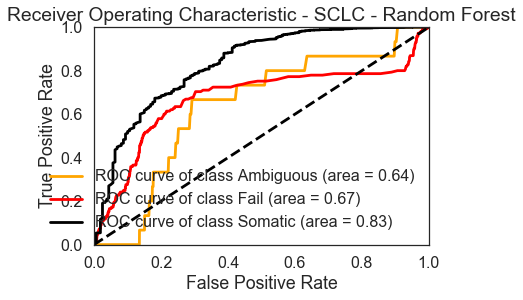

In [70]:
# Print AUC
fig, ax = plt.subplots()
create_roc_curve(sclc_Y_one_hot, sclc_probs, class_lookup, 'Receiver Operating '
                 'Characteristic - SCLC - Random Forest', ax)

## Access how much test data is need in training to rescue performance and compensate for batch effects

In [71]:
auc = []

for i in np.arange(0, 0.8, 0.05):
    if i == 0:
        sclc_X_test = sclc_X
        sclc_Y_test = sclc_Y
        X_train = X
        Y_train = Y
    else:
        (sclc_X_train, sclc_X_test, 
         sclc_Y_train, sclc_Y_test) = train_test_split(sclc_X, sclc_Y, 
                                                       train_size=i,
                                                       random_state=seed, 
                                                       stratify=sclc_Y) 
        X_train = np.concatenate((X, sclc_X_train))
        Y_train = np.concatenate((Y, sclc_Y_train))
    print('Percentage of test data included in training: ', i*100)
    print('Training data shape: ', X_train.shape)
    print('Test data shape: ', sclc_X_test.shape)
    print('Number of test samples included in training: ', X_train.shape[0]-X.shape[0])
    forest = estimator.fit(X_train, Y_train)
    X_test_probs = forest.predict_proba(sclc_X_test)
    sclc_Y_test_one_hot = enc.fit_transform(sclc_Y_test)
    print_accuracy_and_classification_report(sclc_Y_test_one_hot, predict_classes(X_test_probs))
    temp_auc = []
    temp_auc.append(X_train.shape[0]-X.shape[0])
    Y_one_hot = enc.fit_transform(Y)
    for j in range(Y_one_hot.shape[1]):
        temp_auc.append(metrics.roc_auc_score(sclc_Y_test_one_hot[:, j], X_test_probs[:, j]))
    auc.append(temp_auc)
    print('Test AUC: ', temp_auc)
    print('---------------------------------------------------------')

Percentage of test data included in training:  0.0
Training data shape:  (41000, 59)
Test data shape:  (2686, 59)
Number of test samples included in training:  0
Cross validation accuracy:
	 0.806403574088

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        15
          1       0.11      0.15      0.13       145
          2       0.97      0.85      0.91      2526

avg / total       0.92      0.81      0.86      2686

Test AUC:  [0, 0.63582927742418571, 0.70369797391740962, 0.82580908551068877]
---------------------------------------------------------
Percentage of test data included in training:  5.0
Training data shape:  (41134, 59)
Test data shape:  (2552, 59)
Number of test samples included in training:  134


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Cross validation accuracy:
	 0.936520376176

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        14
          1       0.48      0.14      0.22       138
          2       0.97      0.99      0.98      2400

avg / total       0.94      0.94      0.93      2552

Test AUC:  [134, 0.81912079252504788, 0.90528379141001158, 0.92772478070175446]
---------------------------------------------------------
Percentage of test data included in training:  10.0
Training data shape:  (41268, 59)
Test data shape:  (2418, 59)
Number of test samples included in training:  268


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Cross validation accuracy:
	 0.948717948718

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        13
          1       0.74      0.26      0.38       131
          2       0.96      0.99      0.98      2274

avg / total       0.94      0.95      0.94      2418

Test AUC:  [268, 0.85114345114345114, 0.92419984178746772, 0.93984840711423823]
---------------------------------------------------------
Percentage of test data included in training:  15.0
Training data shape:  (41402, 59)
Test data shape:  (2284, 59)
Number of test samples included in training:  402


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Cross validation accuracy:
	 0.949649737303

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        13
          1       0.71      0.30      0.42       123
          2       0.96      0.99      0.98      2148

avg / total       0.94      0.95      0.94      2284

Test AUC:  [402, 0.85252176269349322, 0.93060085853056573, 0.94082730857706209]
---------------------------------------------------------
Percentage of test data included in training:  20.0
Training data shape:  (41537, 59)
Test data shape:  (2149, 59)
Number of test samples included in training:  537


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Cross validation accuracy:
	 0.949278734295

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        12
          1       0.69      0.31      0.43       116
          2       0.96      0.99      0.98      2021

avg / total       0.94      0.95      0.94      2149

Test AUC:  [537, 0.85236312587739826, 0.9373102430585003, 0.94395178748144482]
---------------------------------------------------------
Percentage of test data included in training:  25.0
Training data shape:  (41671, 59)
Test data shape:  (2015, 59)
Number of test samples included in training:  671


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Cross validation accuracy:
	 0.952853598015

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        11
          1       0.72      0.39      0.50       109
          2       0.96      0.99      0.98      1895

avg / total       0.95      0.95      0.95      2015

Test AUC:  [671, 0.83562420613318822, 0.93860046015961196, 0.94144459102902378]
---------------------------------------------------------
Percentage of test data included in training:  30.0
Training data shape:  (41805, 59)
Test data shape:  (1881, 59)
Number of test samples included in training:  805


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Cross validation accuracy:
	 0.95427963849

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        10
          1       0.78      0.37      0.50       102
          2       0.96      0.99      0.98      1769

avg / total       0.95      0.95      0.95      1881

Test AUC:  [805, 0.84374665954035277, 0.95412712583628168, 0.95267705725591534]
---------------------------------------------------------
Percentage of test data included in training:  35.0
Training data shape:  (41940, 59)
Test data shape:  (1746, 59)
Number of test samples included in training:  

/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


940
Cross validation accuracy:
	 0.958190148912

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        10
          1       0.85      0.41      0.56        94
          2       0.96      1.00      0.98      1642

avg / total       0.95      0.96      0.95      1746

Test AUC:  [940, 0.83712557603686633, 0.95075601463087944, 0.94991450388831644]
---------------------------------------------------------
Percentage of test data included in training:  40.0
Training data shape:  (42074, 59)
Test data shape:  (1612, 59)
Number of test samples included in training:  1074


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Cross validation accuracy:
	 0.95905707196

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         9
          1       0.84      0.44      0.58        87
          2       0.97      0.99      0.98      1516

avg / total       0.95      0.96      0.95      1612

Test AUC:  [1074, 0.83430373605046093, 0.95288863764838894, 0.95180917436235701]
---------------------------------------------------------
Percentage of test data included in training:  45.0
Training data shape:  (42208, 59)
Test data shape:  (1478, 59)
Number of test samples included in training:  1208


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Cross validation accuracy:
	 0.960757780785

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         8
          1       0.92      0.42      0.58        80
          2       0.96      1.00      0.98      1390

avg / total       0.96      0.96      0.95      1478

Test AUC:  [1208, 0.85739795918367345, 0.96588429899856931, 0.96180918901242651]
---------------------------------------------------------
Percentage of test data included in training:  50.0
Training data shape:  (42343, 59)
Test data shape:  (1343, 59)
Number of test samples included in training:  1343


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Cross validation accuracy:
	 0.962769918094

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         7
          1       0.94      0.44      0.60        73
          2       0.97      1.00      0.98      1263

avg / total       0.96      0.96      0.96      1343

Test AUC:  [1343, 0.83682634730538918, 0.96636285190378612, 0.95798198733174988]
---------------------------------------------------------
Percentage of test data included in training:  55.0
Training data shape:  (42477, 59)
Test data shape:  (1209, 59)
Number of test samples included in training:  1477


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Cross validation accuracy:
	 0.963606286187

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         7
          1       0.91      0.48      0.63        65
          2       0.97      1.00      0.98      1137

avg / total       0.96      0.96      0.96      1209

Test AUC:  [1477, 0.82386498692655097, 0.96904922001075855, 0.95815621030000986]
---------------------------------------------------------
Percentage of test data included in training:  60.0
Training data shape:  (42611, 59)
Test data shape:  (1075, 59)
Number of test samples included in training:  1611


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Cross validation accuracy:
	 0.963720930233

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         6
          1       0.93      0.47      0.62        58
          2       0.97      1.00      0.98      1011

avg / total       0.96      0.96      0.96      1075

Test AUC:  [1611, 0.78609292173370759, 0.96868748516597158, 0.95244498021760637]
---------------------------------------------------------
Percentage of test data included in training:  65.0
Training data shape:  (42745, 59)
Test data shape:  (941, 59)
Number of test samples included in training:  1745


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Cross validation accuracy:
	 0.965993623804

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         5
          1       0.96      0.49      0.65        51
          2       0.97      1.00      0.98       885

avg / total       0.96      0.97      0.96       941

Test AUC:  [1745, 0.78931623931623929, 0.96687596386869346, 0.94934422921711059]
---------------------------------------------------------
Percentage of test data included in training:  70.0
Training data shape:  (42880, 59)
Test data shape:  (806, 59)
Number of test samples included in training:  1880


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Cross validation accuracy:
	 0.966501240695

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       1.00      0.48      0.65        44
          2       0.97      1.00      0.98       758

avg / total       0.96      0.97      0.96       806

Test AUC:  [1880, 0.80610972568578554, 0.96304581245526122, 0.94988181618293743]
---------------------------------------------------------
Percentage of test data included in training: 

/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


 75.0
Training data shape:  (43014, 59)
Test data shape:  (672, 59)
Number of test samples included in training:  2014
Cross validation accuracy:
	 0.964285714286

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.94      0.47      0.63        36
          2       0.96      1.00      0.98       632

avg / total       0.96      0.96      0.96       672

Test AUC:  [2014, 0.84393712574850299, 0.96224231306778474, 0.9450949367088608]
---------------------------------------------------------


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


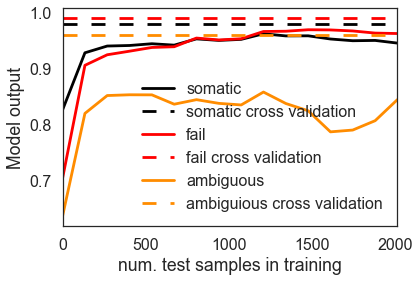

In [72]:
# Plot batch effects compensation
sclc_auc = pd.DataFrame(auc, columns=['num. test samples in training','ambiguous', 'fail','somatic'])
fig, ax = plt.subplots(1, 1)
sclc_auc.plot(x='num. test samples in training', y='somatic', ax=ax, color='black')
ax.plot([0, 2000], [.98,.98], linestyle='--', dashes=(5, 5),color='black', label='somatic cross validation')
sclc_auc.plot(x='num. test samples in training', y='fail', ax=ax, color='red')
ax.plot([0, 2000], [.99,.99], linestyle='--', dashes=(5, 5),color='red', label='fail cross validation')
sclc_auc.plot(x='num. test samples in training', y='ambiguous', ax=ax, color='darkorange')
ax.plot([0, 2000], [.96,.96], linestyle='--', dashes=(5, 5),color='darkorange', label='ambiguious cross validation')
ax.set_ylabel('Model output')
ax.legend()

In [73]:
# Save data to rf folder
sclc_auc.to_pickle('../data/random_forest/sclc_batch_effect_correction.pkl')